# Exploratory Data Analysis - Crime Data Los Angeles

This notebook is used to explore the questions for the Data Scientist Exercise in July 2020.

- How many crimes were reported over the past 5 years?
- List the top five reported crimes for each year for the past 5 years.
- What are the most common MO codes? Have these changed over the past 5 years?
- How else has reported crime changed over time in the City?
- Based on your analysis, please share any changes to services, programs, or policies that the City should consider.

##  Load libraries

In [81]:
# Import libraries
import os, sys, subprocess
import json
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

In [24]:
# load project config
terminal_call = ! git rev-parse --show-toplevel
repo_path=terminal_call[0]
project_config_path = os.path.join(repo_path,'project_config.json')

with open(project_config_path,'r') as fp: 
    project_config = json.load(fp)

In [25]:
# import custom module to look at trends
module_path = os.path.join(repo_path,project_config['project_module_relative_path'])
sys.path.append(module_path)

import trends
from trends import get_top_trends as gt
from trends import convert
from trends.convert import crime_dict, mocode_dict # load in crime name dictionary
from importlib import reload # for updating scripts

# Load in data

In [31]:
# load in data that was collected
df = pickle.load(open("../data/crime_data.pkl", "rb"))

In [45]:
# Explore summary info
def eda(df):
    nulls = pd.DataFrame(df.isnull().sum()).T # Check for nulls
    datatypes = pd.DataFrame(df.dtypes).T # Check datatypes
    summary = pd.concat([nulls, datatypes], keys = ["nulls", "datatypes"]) # Create pandas dataframe, because I think it's easier to read
    return summary

In [48]:
eda(df)

,,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,year,mocodes_1,mocodes_2,mocodes_3
nulls,0,0,0,0,0,0,0,0,0,0,0,240361,0,208478,208527,55,228,1464999,1465000,3,0,11,2063105,2206364,2209991,0,1837686,0,0,0,0,240361,240361
datatypes,0,int64,datetime64[ns],datetime64[ns],int64,int64,object,int64,int64,int64,object,object,int64,object,object,float64,object,float64,object,object,object,float64,float64,float64,float64,object,object,float64,float64,int64,int64,object,object


## How many crimes were reported over the past 5 years?

In [6]:
# Check how many crimes were reported over the past 5 years
# Calculate current date and offset by 5 years
(df["date_rptd"] > (pd.datetime.now()- pd.DateOffset(years=5))).sum()

1117864

### A: 1,117,864 crimes were reported in the past 5 years

## List the top five reported crimes for each year for the past 5 years.

In [ ]:
reload(trends)

### Subset data for the last 5 years

In [33]:
# Select the last 5 years as a dataframe
df_5 = df[df["date_rptd"] > (pd.datetime.now()- pd.DateOffset(years=5))]

In [34]:
# Find the top 5 reported crimes for each year
# Crime is listed in the data under 'crm_cd'
# Custom function 'top_trends' groups by column and selects the top 'n' 
top_crimes = gt.top_trends(df_5, column='year', variable='crm_cd', n=5)

In [35]:
# Add in the name of the crimes to dataframe
top_crimes["crm_name"] = convert.get_names(top_crimes, "crm_cd", crime_dict)

In [36]:
top_crimes

,year,crm_cd,count,crm_name
0,2015,624,8853,Battery - misdemeanor
1,2015,510,8573,Stolen Vehicle
2,2015,440,7866,Theft - $950 & under
3,2015,330,7316,Burg from Vehicle
4,2015,354,7297,Theft of Identity
131,2016,510,18353,Stolen Vehicle
132,2016,624,17942,Battery - misdemeanor
133,2016,330,16779,Burg from Vehicle
134,2016,440,14814,Theft - $950 & under
135,2016,310,14558,Burglary


## What are the most common MO codes? Have these changed over the past 5 years?

From the summary info above, I see there are 240361 rows of missing MO codes in the original dataframe. I will remove the NA for this question.

In [49]:
df["mocodes"].notnull()

0        True 
1        True 
2        True 
3        True 
4        True 
         ...  
95400    False
95401    True 
95402    True 
95403    True 
95404    True 
Name: mocodes, Length: 2210104, dtype: bool

In [52]:
# Select the last 5 years as a dataframe
df_5 = df_5[df_5["mocodes"].notnull()]

In [53]:
# Find the top 10 most common MO codes across all the years (2010-2020)
df_5["mocodes"].value_counts(ascending = False).head(10)

0344         93842
0329         44407
1501         18472
0325         12737
0416         12317
0329 1300    8302 
1822         8234 
0344 1300    6090 
0344 1606    5898 
0329 1307    4808 
Name: mocodes, dtype: int64

In [54]:
# Find the top 10 MO codes for each year
# MO code is listed in the data under 'mocodes'
# Custom function 'top_trends' groups by column and selects the top 'n' 
top_mo = gt.top_trends(df_5, column='year', variable='mocodes_1', n=10)

In [55]:
# Add in the name of the MO codes to dataframe
top_mo["mo_name"] = convert.get_names(top_mo, "mocodes_1", mocode_dict)

In [79]:
# create a rank column
top_mo["rank"] = top_mo.groupby('year')["count"].rank(ascending=False)

In [78]:
top_mo.head()

,year,mocodes_1,count,mo_name,rank
0,2015,344,24853,Removes vict property,1.0
1,2015,329,9307,Vandalized,2.0
2,2015,2000,5622,Domestic violence,3.0
3,2015,416,5152,Hit-Hit w/ weapon,4.0
4,2015,325,2820,Took merchandise,5.0


(10.45, 0.55)

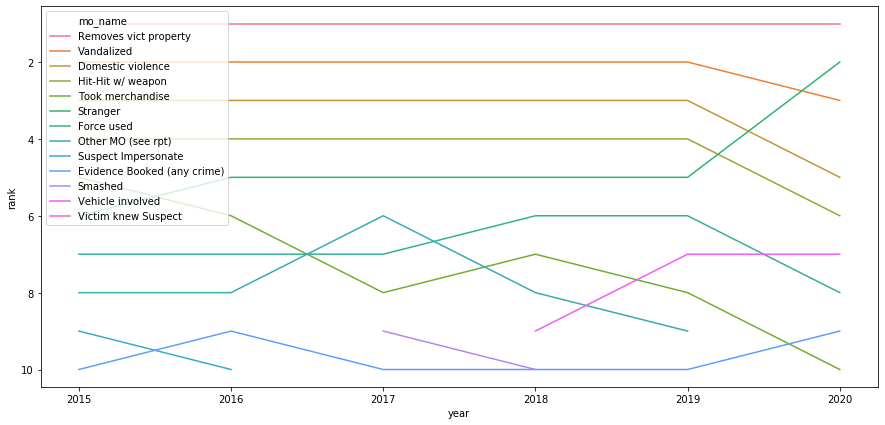

In [128]:
plt.figure(figsize=(15, 7))

ax = sns.lineplot(x="year", y="rank", hue="mo_name", markers = True,
                  data=top_mo)

plt.ylim(reversed(plt.ylim()))